In [1]:
import os
from utils import load_jsonl_iteratively, load_jsonl

In [15]:
def get_model_loss(exp_name, num_iter):
    # Collect the loss information from adaxeval evaluation result.json
    lang = "ja"
    eval_type = "generalization"
    id2loss = {}
    model_root = f"/data/xzhao/experiments/roman-pretrain/exps/{exp_name}/hf_models"
    if num_iter == "last":
        if exp_name == "exp1-en_jstage":
            checkpoint_folder = "iter_0003838"
        elif exp_name == "exp2-medical-en_jstage":
            checkpoint_folder = "iter_0007679"
        elif exp_name == "exp3-medical-en_jstage":
            checkpoint_folder = "iter_0007659"
        elif exp_name == "exp3-balanced-en_jstage":
            checkpoint_folder = "iter_0007718"
        elif exp_name == "exp3-science-en_jstage":
            checkpoint_folder = "iter_0007706"
        elif exp_name == "exp4-medical-en_jstage":
            checkpoint_folder = "iter_0007689"
        elif exp_name == "exp5-medical-en_jstage":
            checkpoint_folder = "iter_0007673"
        else:
            raise NotImplementedError
    
    elif isinstance(int(num_iter), int):
        checkpoint_folder = f"iter_{int(num_iter):07d}"
    checkpoint_folder = os.path.join(model_root, checkpoint_folder)
    assert os.path.exists(checkpoint_folder), f"Checkpoint folder does not exist: {checkpoint_folder}"
    # print(f"Loading losses from {checkpoint_folder} ...")

    target_dataset = f"{lang}_knowledge_{eval_type}"
    result_filename = os.path.join(checkpoint_folder, "adaxeval.jsonl")
    for item in load_jsonl_iteratively(result_filename):
        sample_id = item["sample"]["sample_id"]
        if item["sample"]['dataset'] != target_dataset:
            continue
        
        id2loss[sample_id] = {
            "total_loss": item['losses'], 
            "norm_loss": item['norm_losses'],
            "answer_idx": item["sample"]["answer_idx"]
        }
    return id2loss

In [17]:
from tqdm import tqdm

monolingual = {}
medicalja_id2loss, medicaltrans_id2loss, balancedtrans_ids2loss = {}, {}, {}
sciencetrans_id2loss, romain_id2loss, en2romain_id2loss = {}, {}, {}

for i in tqdm(range(0, 5000, 1000)):
    i = 'last' if i == 4000 else i
    id2loss = get_model_loss("exp1-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        monolingual.setdefault(sample_id, []).append(id2loss[sample_id])
    
for i in tqdm(range(0, 9000, 1000)):
    i = 'last' if i == 8000 else i
    id2loss = get_model_loss("exp2-medical-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        medicalja_id2loss.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("exp3-medical-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        medicaltrans_id2loss.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("exp3-balanced-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        balancedtrans_ids2loss.setdefault(sample_id, []).append(id2loss[sample_id])

    id2loss = get_model_loss("exp3-science-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        sciencetrans_id2loss.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("exp4-medical-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        romain_id2loss.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("exp5-medical-en_jstage", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en2romain_id2loss.setdefault(sample_id, []).append(id2loss[sample_id])


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


In [18]:
do_filtering = True

import numpy as np
def analyize(title, id2loss):
    forget, acquired, keepin, keepout = 0, 0, 0, 0
    for sample_id, losses in list(id2loss.items()):
        init_match = losses[0]['answer_idx'] == np.asarray(losses[0]['norm_loss']).argmin()
        final_match = losses[-1]['answer_idx'] == np.asarray(losses[-1]['norm_loss']).argmin()
        if init_match and final_match:
            keepin += 1
        elif init_match and (not final_match):
            forget += 1
        elif (not init_match) and final_match:
            acquired += 1
        else:
            keepout += 1

    print(f"------- {title} -------")
    # print(f"Forget: {forget}, Acquired: {acquired}, Keep In: {keepin}, Keep Out: {keepout}, all: {len(id2loss)}")
    print(f"Forget: {forget/len(id2loss):.3%}, Acquired: {acquired/len(id2loss):.3%}, Keep In: {keepin/len(id2loss):.3%}, Keep Out: {keepout/len(id2loss):.3%}")
            
analyize("Monolingual: ", monolingual)
analyize("Medical-Japanese: ", medicalja_id2loss)
analyize("Medical-Translation: ", medicaltrans_id2loss)
analyize("Balanced-Translation: ", balancedtrans_ids2loss)
analyize("Science-Translation: ", sciencetrans_id2loss)
analyize("Medical-Romain: ", romain_id2loss)
analyize("Medical-Roman2En: ", en2romain_id2loss)

------- Monolingual:  -------
Forget: 5.523%, Acquired: 10.537%, Keep In: 29.416%, Keep Out: 54.524%
------- Medical-Japanese:  -------
Forget: 4.622%, Acquired: 11.594%, Keep In: 30.317%, Keep Out: 53.467%
------- Medical-Translation:  -------
Forget: 4.269%, Acquired: 12.025%, Keep In: 30.670%, Keep Out: 53.036%
------- Balanced-Translation:  -------
Forget: 6.855%, Acquired: 10.302%, Keep In: 28.085%, Keep Out: 54.759%
------- Science-Translation:  -------
Forget: 8.265%, Acquired: 10.106%, Keep In: 26.675%, Keep Out: 54.955%
------- Medical-Romain:  -------
Forget: 4.348%, Acquired: 10.811%, Keep In: 30.591%, Keep Out: 54.250%
------- Medical-Roman2En:  -------
Forget: 4.700%, Acquired: 8.892%, Keep In: 30.239%, Keep Out: 56.169%


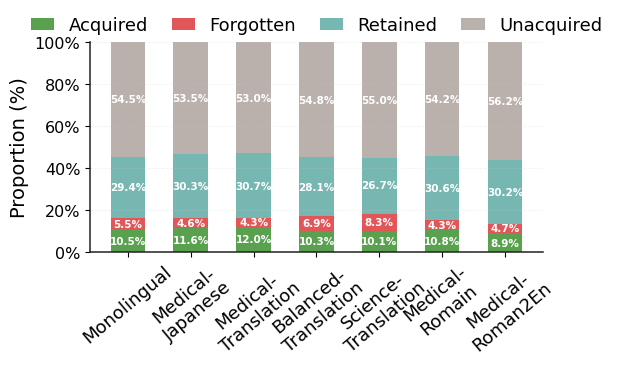

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Data
titles = [
    "Monolingual", "Medical-\nJapanese", "Medical-\nTranslation", "Balanced-\nTranslation",
    "Science-\nTranslation", "Medical-\nRomain", "Medical-\nRoman2En"
]
forgotten =  np.array([5.523, 4.622, 4.269, 6.855, 8.265, 4.348, 4.700])
acquired  =  np.array([10.537, 11.594, 12.025, 10.302, 10.106, 10.811, 8.892])
retained  =  np.array([29.416, 30.317, 30.670, 28.085, 26.675, 30.591, 30.239])
unacquired = np.array([54.524, 53.467, 53.036, 54.759, 54.955, 54.250, 56.169])

# Font and style
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 11.5,
    "axes.labelsize": 12,
    "axes.titlesize": 13.5,
    "axes.linewidth": 1.1,
    "axes.edgecolor": "#222222",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "#cccccc",
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "legend.fontsize": 11,
})

colors = {
    "Acquired": "#59a14f",     # green
    "Forgotten": "#e15759",    # red
    "Retained": "#76b7b2",     # blue
    "Unacquired": "#bab0ac"    # gray
}

# Plot
fig, ax = plt.subplots(figsize=(6.2, 4.0))
x = np.arange(len(titles))

# Compute cumulative bottoms
bottom_acq = np.zeros_like(acquired)
bottom_fgt = acquired
bottom_ret = acquired + forgotten
bottom_unq = acquired + forgotten + retained


bars_acq = ax.bar(x, acquired, color=colors["Acquired"], label="Acquired", width=0.55)
bars_fgt = ax.bar(x, forgotten, bottom=bottom_fgt, color=colors["Forgotten"], label="Forgotten", width=0.55)
bars_ret = ax.bar(x, retained, bottom=bottom_ret, color=colors["Retained"], label="Retained", width=0.55)
bars_unq = ax.bar(x, unacquired, bottom=bottom_unq, color=colors["Unacquired"], label="Unacquired", width=0.55)

# Add percentage labels
def add_labels(bars, values, bottoms):
    for bar, val, bot in zip(bars, values, bottoms):
        if val > 2:  # only label if segment > 2%
            ax.text(
                bar.get_x() + bar.get_width()/2, bot + val/2,
                f"{val:.1f}%", ha="center", va="center",
                fontsize=7.5, color="white", fontweight="bold"
            )

add_labels(bars_acq, acquired, bottom_acq)
add_labels(bars_fgt, forgotten, bottom_fgt)
add_labels(bars_ret, retained, bottom_ret)
add_labels(bars_unq, unacquired, bottom_unq)

# Axis setup
ax.set_xticks(x)
ax.set_xticklabels(titles, fontsize=13, rotation=40)
ax.set_ylim(0, 100)
ax.set_ylabel("Proportion (%)", fontsize=14, labelpad=4)
ax.yaxis.set_major_formatter(PercentFormatter(100))
ax.grid(axis="y", alpha=0.25)

# Legend
ax.legend(
    ncol=4, frameon=False, loc="upper center", fontsize=13,
    bbox_to_anchor=(0.5, 1.2), handlelength=1.3, columnspacing=1.3
)


plt.tight_layout()
plt.savefig("../figures/crosslingual_analysis_bar.pdf", dpi=300, bbox_inches="tight")
plt.show()

